# TF-MoDISco on the Nanog GkmExplain Scores

This notebook demonstrates running TF-MoDISco on importance scores obtained from GkmExplain on Nanog ChIP-seq data in H1ESCs. See [this notebook](https://github.com/kundajelab/tfmodisco/blob/de01768331fd63df6cb9d6b9707589928194a1e4/examples/H1ESC_Nanog_gkmsvm/Nanog_GkmExplain_Generate_Data.ipynb) for how to produce the scores.

In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import sys
print (sys.version)
import os

TF-MoDISco is using the TensorFlow backend.
/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/a

3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Grab the input data

In [3]:
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/positives_test.fa.gz -O positives_test.fa.gz
!gunzip -f positives_test.fa.gz 
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/gkmexplain_positives_hypimpscores.txt.gz -O gkmexplain_positives_hypimpscores.txt.gz
!gunzip -f gkmexplain_positives_hypimpscores.txt.gz
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/gkmexplain_dnshuff_hypimpscores.txt.gz -O gkmexplain_dnshuff_hypimpscores.txt.gz
!gunzip -f gkmexplain_dnshuff_hypimpscores.txt.gz
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/dnshuff_seqs.fa.gz -O dnshuff_seqs.fa.gz
!gunzip -f dnshuff_seqs.fa.gz

--2020-04-21 15:43:20--  https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/positives_test.fa.gz
Resolving raw.githubusercontent.com... 151.101.40.133
Connecting to raw.githubusercontent.com|151.101.40.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75038 (73K) [application/octet-stream]
Saving to: 'positives_test.fa.gz'

100%[======================================>] 75,038      --.-K/s   in 0.04s   

2020-04-21 15:43:20 (1.68 MB/s) - 'positives_test.fa.gz' saved [75038/75038]

--2020-04-21 15:43:21--  https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/gkmexplain_positives_hypimpscores.txt.gz
Resolving raw.githubusercontent.com... 151.101.40.133
Connecting to raw.githubusercontent.com|151.101.40.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3191036 (3.0M) [application/octet-stream]
Saving to: 'gkmexplain_positives_hypimpscores.txt.gz'

100%[=

### Read in the one-hot encoded sequences and scores

In [4]:
import numpy as np

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1


def read_in_seqs_and_scores(fa_file, hypimpscores_file):
    seqs = [x.rstrip() for (i,x) in enumerate(open(fa_file)) if i%2==1]
    #filter out any sequences that contain 'N's
    onehot_data = [np.array(one_hot_encode_along_channel_axis(x))
                   for x in seqs if ('N' not in x)]
    #read in the hypothetical importance scores,
    # filter out any sequences that contain 'N's
    unnorm_hyp_impscores = [w[0] for w in zip([
        np.array( [[float(z) for z in y.split(",")]
            for y in x.rstrip().split("\t")[2].split(";")])
        for x in open(hypimpscores_file)],seqs)
        if 'N' not in w[1]]
    #in the original GkmExplain paper, a normalization of the importance scores and
    # hypothetical importance scores was proposed, as this was empirically observed to improve
    # the signal-to-noise ratio. Here, I will do a similar-in-spirit normalization that also
    # appears to improve the signal-to-noise ratio, but which is more intuitive and better-motivated
    # than the normalization from the gkmexplain paper (the reason I didn't propose it in that paper
    # is simply that I hadn't considered it).
    #The normalization consists of subtracting the mean hypothetical importance across ACGT at each
    # position such that the sum of the hypothetical importance at each position is 0. The intuition
    # is that this highlights the impact of each base on the output **relative to the other bases that
    # could have been present**. The normalized actual importance is simply the normalized hypothetical
    # importance multiplied by the one-hot encoding.
    hyp_impscores = [x - np.mean(x, axis=-1)[:,None] for x in unnorm_hyp_impscores]
    impscores = [x*y for x,y in zip(hyp_impscores, onehot_data)]
    
    return onehot_data, hyp_impscores, impscores
    

onehot_data, hyp_impscores, impscores = read_in_seqs_and_scores(
    fa_file="positives_test.fa",
    hypimpscores_file="gkmexplain_positives_hypimpscores.txt")
print("Num onehot sequences:",len(onehot_data))

_, _, nulldist_impscores = read_in_seqs_and_scores(
    fa_file="dnshuff_seqs.fa",
    hypimpscores_file="gkmexplain_dnshuff_hypimpscores.txt")
nulldist_perposimp = np.sum(nulldist_impscores, axis=-1)

Num onehot sequences: 960


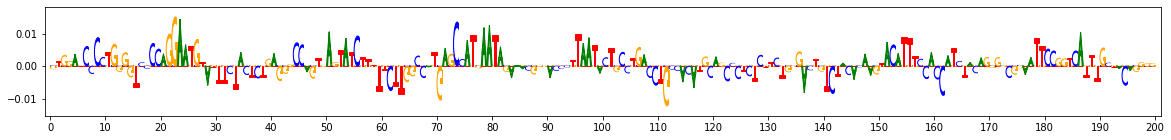

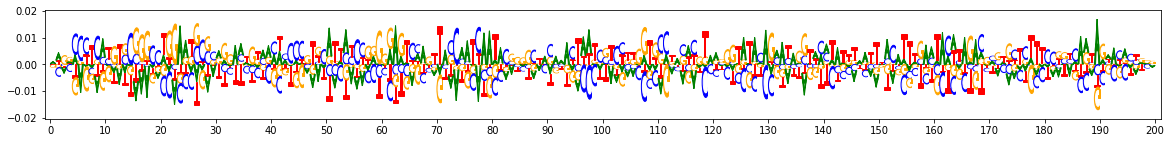

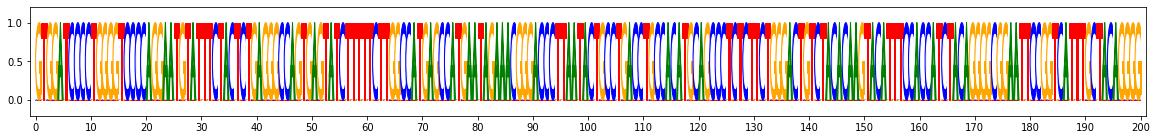

In [5]:
from matplotlib import pyplot as plt
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(impscores[0], subticks_frequency=10)
viz_sequence.plot_weights(hyp_impscores[0], subticks_frequency=10)
viz_sequence.plot_weights(onehot_data[0], subticks_frequency=10)


## Run TF-MoDISco

To demonstrate customization, the code below has the following modifications from the default settings:
- An empirical null distribution is supplied for per-position importance scores using the argument `null_per_pos_scores`
- `target_seqlet_fdr` controls the noisiness of the seqlets. For a particular task, importance scores are first smoothed with a window of size `sliding_window_size` (default value of 21 at the time of writing), and the FDR for scores in sliding windows is estimated using the supplied empirical null distribution. This is used to set a threshold on sliding windows that can go on to form seqlets. Note: if the number of sliding windows that pass the FDR threshold is smaller than `min_passing_windows_frac` (default value 0.03 at the time of writing) or larger than `max_passing_windows_frac` (default value of 0.2 at the time of writing), the threshold will be adjusted.
- (new in version 0.5.6.0) MEME is run on the seqlets to find 10 motifs, and the significant motifs are used to initialize TF-MoDISco's Leiden clustering. This initialization is handled by the initclusterer_factory argument.
- The code below uses kmers of length 5 with 1 gap and no mismatches to compute the "quick and dirty" affinity matrix across all seqlets. The "quick and dirty" affinity matrix is used both for noise filtering and as a first pass to speed up computation of the continuous jaccard affinity matrix (the latter affinities are only computed between seqlets deemed to be close together by the "quick and dirty" method). I made the kmer length smaller to keep memory usage on the GPU down when testing on my macbook pro. The default is to use kmers of length 8 with 3 gaps and 2 mismatches, and this works fine when run on some computing servers, but not when run on my 6-year-old personal laptop.
- The `final_min_cluster_size` is set to 10 rather than the default of 30. The `final_min_cluster_size` determines the minimum support needed (in terms of number of seqlets) for a cluster to be displayed. It was lowered here to potentially enable better comparison to the MEME results, as the MEME motifs can sometimes have very few seqlets.

MEMORY 0.326619136
On task task0
Computing windowed sums on original
Generating null dist
Computing threshold


TF-MoDISco is using the TensorFlow backend.


Thresholds from null dist were -0.21752344639999993  and  0.13906743924999995
Final raw thresholds are -0.21752344639999993  and  0.13906743924999995
Final transformed thresholds are -0.9723900462962963  and  0.8939699074074074


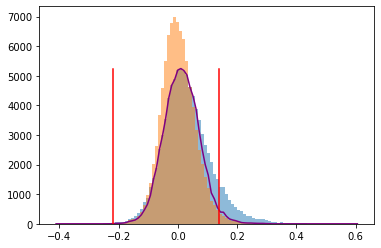

Got 1106 coords
After resolving overlaps, got 1106 seqlets
Across all tasks, the weakest transformed threshold used was: 0.8938699074074075
MEMORY 0.333705216
1106 identified in total
1 activity patterns with support >= 100 out of 3 possible patterns
Metacluster sizes:  [1086]
Idx to activities:  {0: '1'}
MEMORY 0.333713408
On metacluster 0
Metacluster size 1086
Relevant tasks:  ('task0',)
Relevant signs:  (1,)

TfModiscoSeqletsToPatternsFactory: seed=1234
Running MEME
Command: meme meme_out/metacluster0/inp_seqlets.fa -dna -mod anr -nmotifs 10 -minw 6 -maxw 50 -oc meme_out/metacluster0
Duration of MEME: 894.4427168369293 seconds
Skipping motif GGVVTGCACATTCCWGGCMTTCYTT as e-value 0.078 does not meet threshold of 0.05
Skipping motif CYCCCCYCCSCCCCC as e-value 0.18 does not meet threshold of 0.05
Of 1086 seqlets, cluster assignments are: Counter({0: 300, 1: 195, 3: 189, 2: 180, 6: 68, 5: 59, 7: 46, 4: 27, -1: 22})
Aggregating for cluster 0 with 300 seqlets
MEMORY 0.363532288
Trimmed 30 

Using TensorFlow backend.


Finished embedding computation in 9.29 s
Starting affinity matrix computations
Normalization computed in 0.16 s
Cosine similarity mat computed in 0.26 s
Normalization computed in 0.15 s
Cosine similarity mat computed in 0.27 s
Finished affinity matrix computations in 0.56 s
(Round 1) Compute nearest neighbors from coarse affmat
MEMORY 0.647806976
Computed nearest neighbors in 1.15 s
MEMORY 0.659628032
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 0.659628032
Launching nearest neighbors affmat calculation job
MEMORY 0.675987456
Parallel runs completed
MEMORY 0.556249088
Job completed in: 47.78 s
MEMORY 0.556253184
Launching nearest neighbors affmat calculation job
MEMORY 0.554795008
Parallel runs completed
MEMORY 0.55877632
Job completed in: 70.91 s
MEMORY 0.568213504
(Round 1) Computed affinity matrix on nearest neighbors in 119.2 s
MEMORY 0.570011648
Filtered down to 992 of 1086
(Round 1) Retained 992 rows out of 1086 after filtering
MEMORY 0.57018368
(Round 1) Compu

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.6514071337843735


  2%|▏         | 1/50 [00:00<00:30,  1.63it/s]

Quality: 0.6514853923788336


  4%|▍         | 2/50 [00:00<00:25,  1.88it/s]

Quality: 0.6516695538926911


 24%|██▍       | 12/50 [00:04<00:12,  3.07it/s]

Quality: 0.651675386906526


 64%|██████▍   | 32/50 [00:11<00:05,  3.00it/s]

Quality: 0.6517180824098234


100%|██████████| 50/50 [00:16<00:00,  3.01it/s]

Got 11 clusters after round 1
Counts:
{2: 157, 5: 64, 3: 100, 0: 269, 4: 75, 6: 36, 7: 29, 1: 216, 9: 19, 8: 25, 10: 2}
MEMORY 0.54081536
(Round 1) Aggregating seqlets in each cluster
MEMORY 0.54081536
Aggregating for cluster 0 with 269 seqlets
MEMORY 0.54081536


Trimmed 19 out of 269
Skipped 31 seqlets
Aggregating for cluster 1 with 216 seqlets
MEMORY 0.54081536
Trimmed 6 out of 216
Skipped 30 seqlets
Aggregating for cluster 2 with 157 seqlets
MEMORY 0.54081536
Trimmed 18 out of 157
Skipped 25 seqlets
Aggregating for cluster 3 with 100 seqlets
MEMORY 0.54081536
Trimmed 7 out of 100
Skipped 18 seqlets
Aggregating for cluster 4 with 75 seqlets
MEMORY 0.54081536
Trimmed 2 out of 75
Skipped 15 seqlets
Aggregating for cluster 5 with 64 seqlets
MEMORY 0.540819456
Trimmed 3 out of 64
Skipped 12 seqlets
Aggregating for cluster 6 with 36 seqlets
MEMORY 0.540819456
Trimmed 0 out of 36
Skipped 3 seqlets
Aggregating for cluster 7 with 29 seqlets
MEMORY 0.540819456
Trimmed 0 out of 29
Skipped 8 seqlets
Aggregating for cluster 8 with 25 seqlets
MEMORY 0.540819456
Trimmed 0 out of 25
Skipped 6 seqlets
Aggregating for cluster 9 with 19 seqlets
MEMORY 0.540819456
Trimmed 0 out of 19
Skipped 8 seqlets
Aggregating for cluster 10 with 2 seqlets
MEMORY 0.540819456

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.5994192637791721


  2%|▏         | 1/50 [00:00<00:14,  3.39it/s]

Quality: 0.5998787510839968


 10%|█         | 5/50 [00:01<00:16,  2.80it/s]

Quality: 0.6006151164524888


 74%|███████▍  | 37/50 [00:09<00:02,  4.51it/s]

Quality: 0.6009656739297115


100%|██████████| 50/50 [00:12<00:00,  4.08it/s]

Got 10 clusters after round 2
Counts:
{0: 234, 7: 6, 1: 161, 2: 126, 5: 32, 6: 7, 8: 4, 3: 115, 4: 94, 9: 2}
MEMORY 0.57546752
(Round 2) Aggregating seqlets in each cluster
MEMORY 0.57546752
Aggregating for cluster 0 with 234 seqlets
MEMORY 0.57546752


Trimmed 34 out of 234
Aggregating for cluster 1 with 161 seqlets
MEMORY 0.57546752
Trimmed 44 out of 161
Aggregating for cluster 2 with 126 seqlets
MEMORY 0.57546752
Trimmed 9 out of 126
Skipped 4 seqlets
Aggregating for cluster 3 with 115 seqlets
MEMORY 0.57546752
Trimmed 7 out of 115
Skipped 2 seqlets
Aggregating for cluster 4 with 94 seqlets
MEMORY 0.57546752
Trimmed 7 out of 94
Skipped 1 seqlets
Aggregating for cluster 5 with 32 seqlets
MEMORY 0.57546752
Trimmed 4 out of 32
Skipped 1 seqlets
Removed 1 duplicate seqlets
Aggregating for cluster 6 with 7 seqlets
MEMORY 0.57546752
Trimmed 0 out of 7
Skipped 2 seqlets
Removed 1 duplicate seqlets
Aggregating for cluster 7 with 6 seqlets
MEMORY 0.57546752
Trimmed 0 out of 6
Removed 1 duplicate seqlets
Aggregating for cluster 8 with 4 seqlets
MEMORY 0.57546752
Trimmed 0 out of 4
Aggregating for cluster 9 with 2 seqlets
MEMORY 0.57546752
Trimmed 0 out of 2
Removed 1 duplicate seqlets
Got 10 clusters
Splitting into subclusters...
MEMORY 0.57

In [6]:
import h5py
import numpy as np
%matplotlib inline
import modisco
reload(modisco)
import modisco.backend
reload(modisco.backend.tensorflow_backend)
reload(modisco.backend)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat.core)
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.tfmodisco_workflow
reload(modisco.tfmodisco_workflow)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.cluster
reload(modisco.cluster.core)
reload(modisco.cluster.phenograph.core)
reload(modisco.cluster.phenograph.cluster)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)
import modisco.clusterinit.memeinit
reload(modisco.clusterinit.memeinit)

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
            target_seqlet_fdr=0.25,
            seqlets_to_patterns_factory=
                modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                    initclusterer_factory=modisco.clusterinit.memeinit.MemeInitClustererFactory(    
                        meme_command="meme", base_outdir="meme_out",   
                        #max_num_seqlets_to_use specifies the maximum number of seqlets to use
                        # with MEME (this is to speed up MEME in the cases where the number of seqlets is
                        #  very large)
                        max_num_seqlets_to_use=10000,
                        nmotifs=10,
                        n_jobs=1),
                    use_louvain=False,
                    #Adjust trim_to_window_size and initial_flank_to_add
                    # according to how big you expect
                    # the core motif to be; default value is 10
                    #trim_to_window_size=6,
                    #initial_flank_to_add=2,
                    #final_flank_to_add=5,
                    #kmer_len, num_gaps and num_mismatches are used to
                    # derive kmer embeddings for coarse-grained affinity
                    # matrix calculation. kmer_len=6, num_gaps=1
                    # and num_mismatches=0 means
                    # that kmer embeddings using 6-mers with 1 gap will be
                    # used.
                    kmer_len=6, num_gaps=1,
                    num_mismatches=0,
                    final_min_cluster_size=10
            ),
       )(
    #There is only one task, so we just call this 'task0'
    task_names=["task0"],
    contrib_scores={'task0': impscores},                
    hypothetical_contribs={'task0': hyp_impscores},
    one_hot=onehot_data,
    null_per_pos_scores={'task0': nulldist_perposimp})

## Save and print the results

In [7]:
import h5py
import modisco.util
reload(modisco.util)
!rm results.hdf5
grp = h5py.File("results.hdf5")
tfmodisco_results.save_hdf5(grp)

Metaclusters heatmap


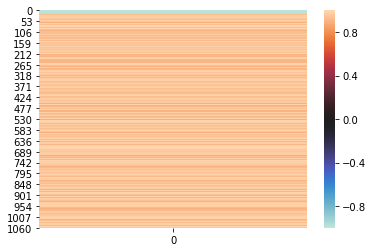

metacluster_0
activity pattern: [1]
metacluster_0 pattern_0
total seqlets: 197
Hypothetical scores:


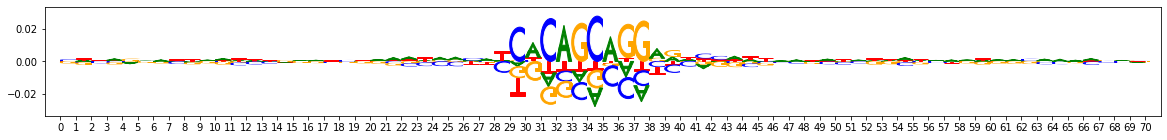

Actual importance scores:


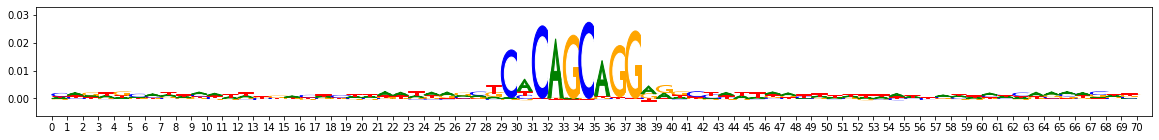

onehot, fwd and rev:


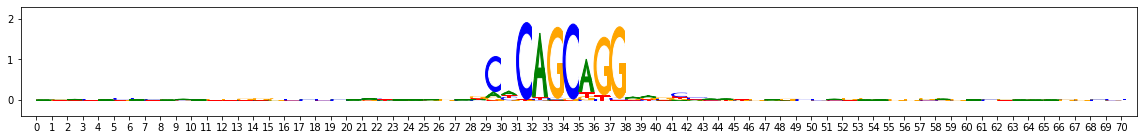

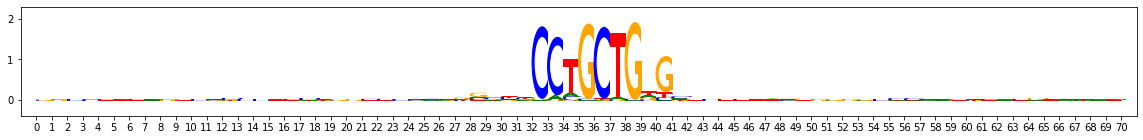

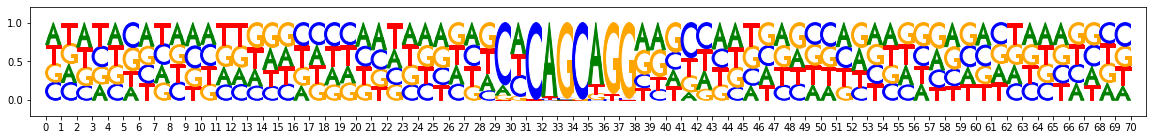

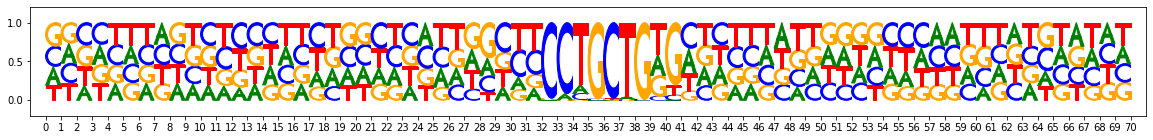

metacluster_0 pattern_1
total seqlets: 167
Hypothetical scores:


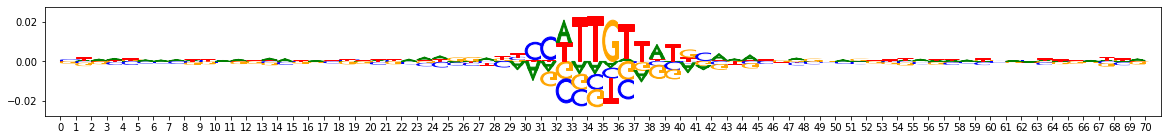

Actual importance scores:


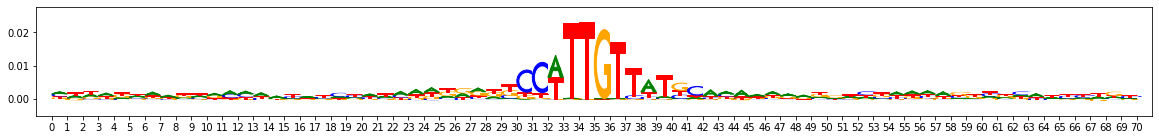

onehot, fwd and rev:


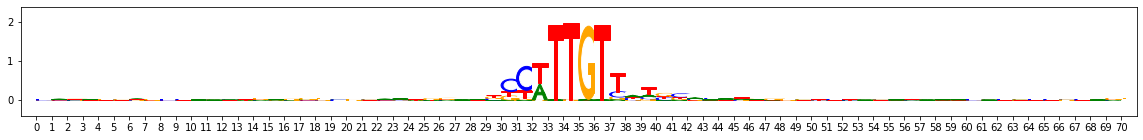

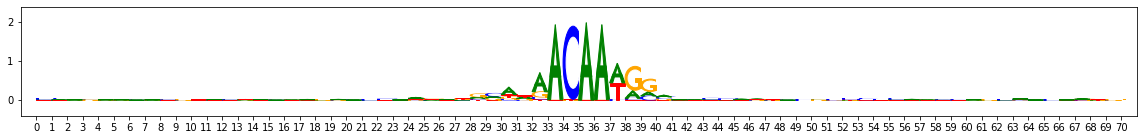

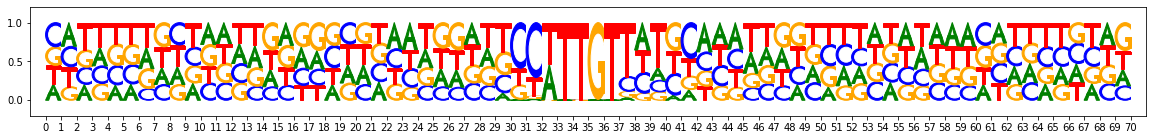

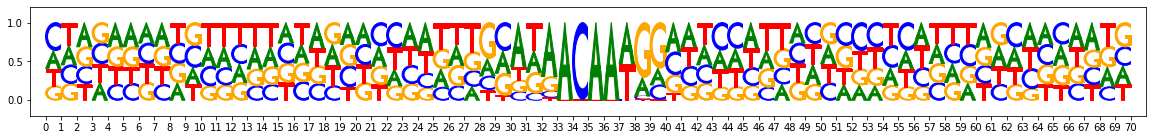

metacluster_0 pattern_2
total seqlets: 107
Hypothetical scores:


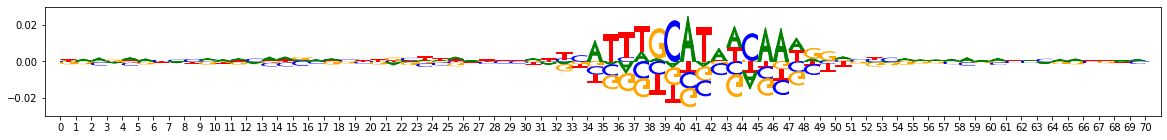

Actual importance scores:


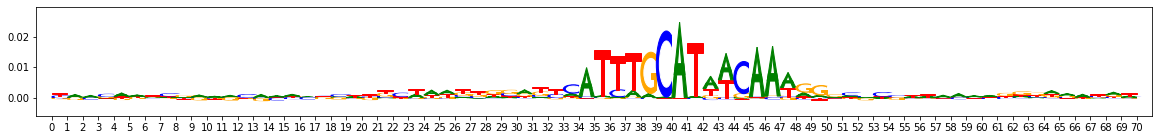

onehot, fwd and rev:


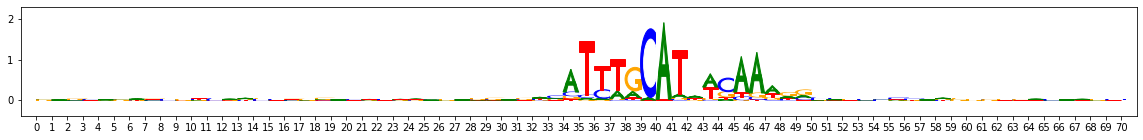

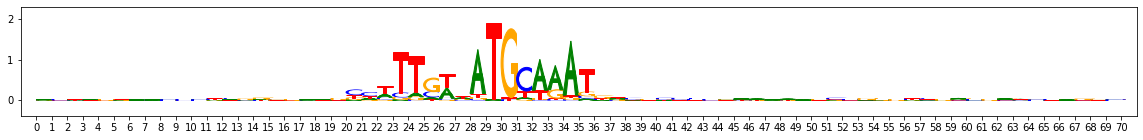

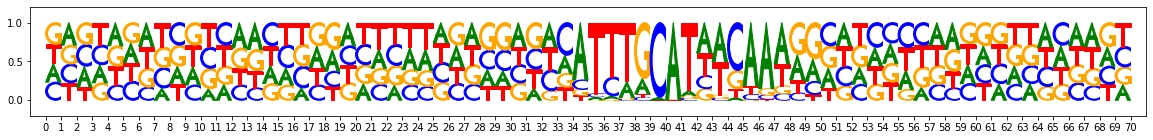

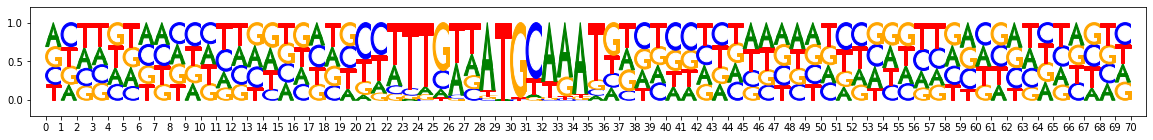

metacluster_0 pattern_3
total seqlets: 49
Hypothetical scores:


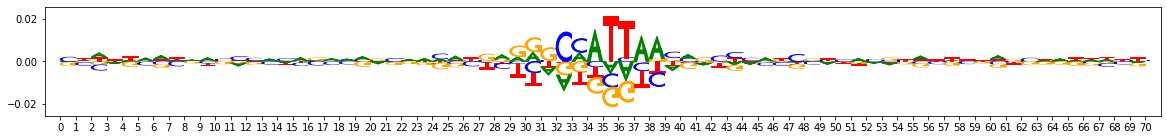

Actual importance scores:


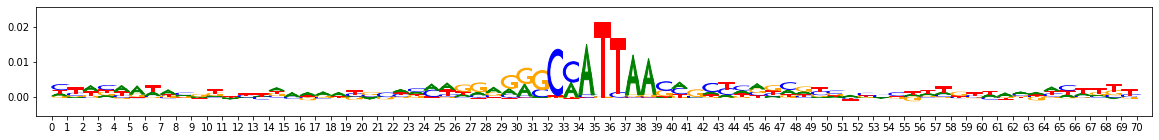

onehot, fwd and rev:


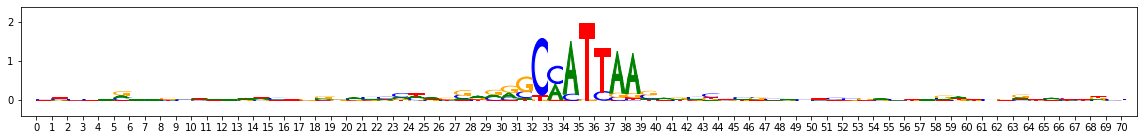

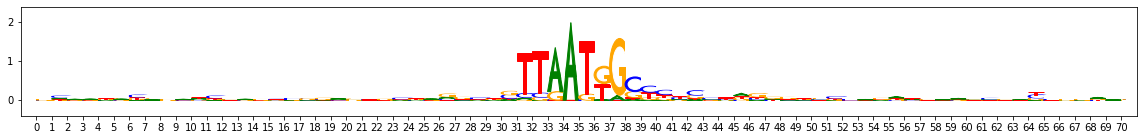

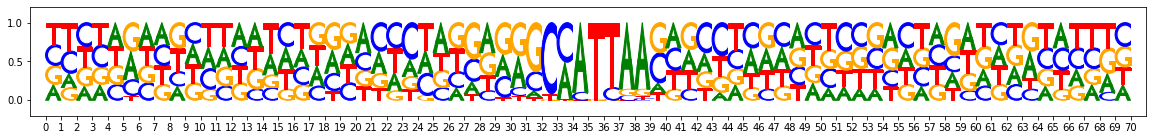

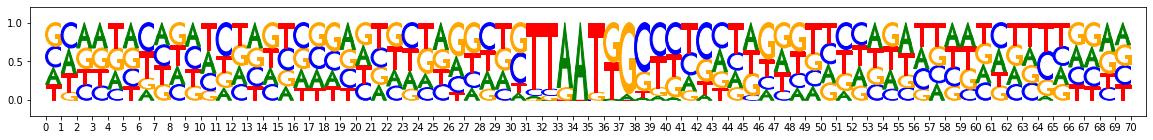

metacluster_0 pattern_4
total seqlets: 48
Hypothetical scores:


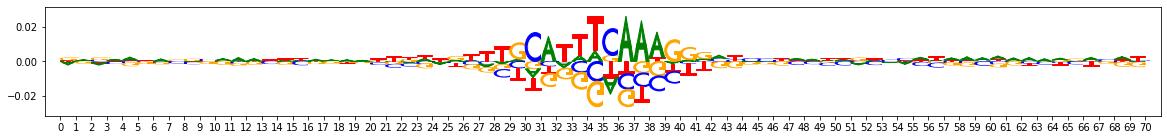

Actual importance scores:


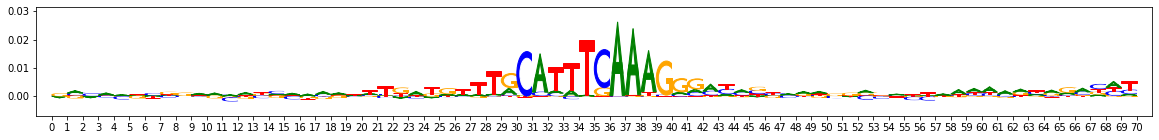

onehot, fwd and rev:


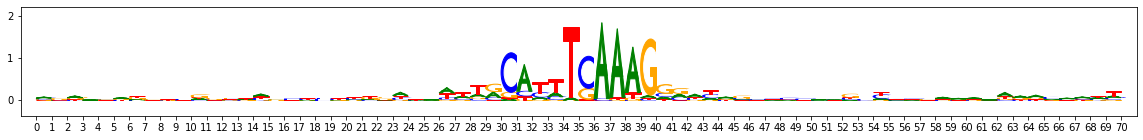

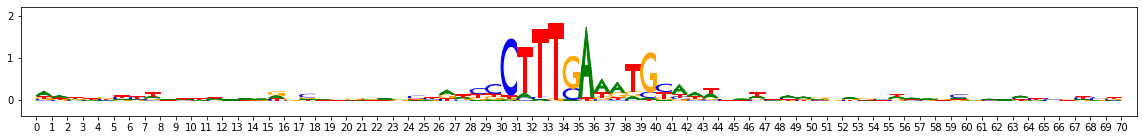

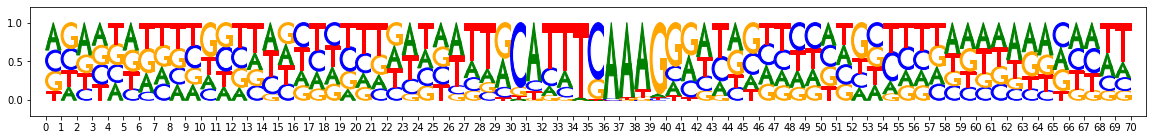

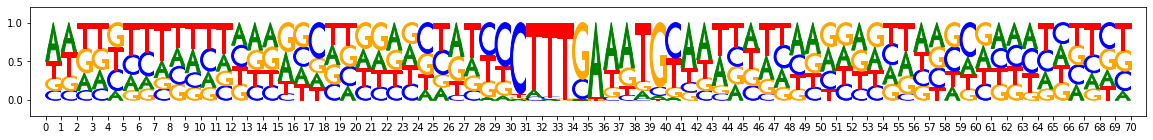

metacluster_0 pattern_5
total seqlets: 37
Hypothetical scores:


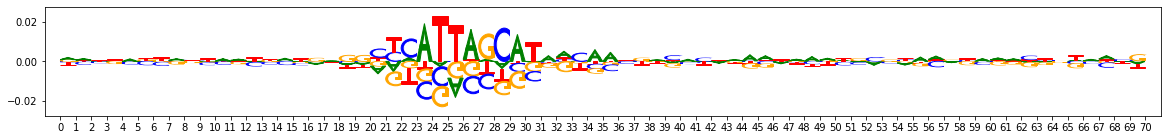

Actual importance scores:


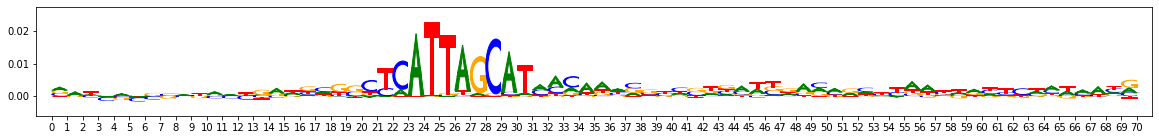

onehot, fwd and rev:


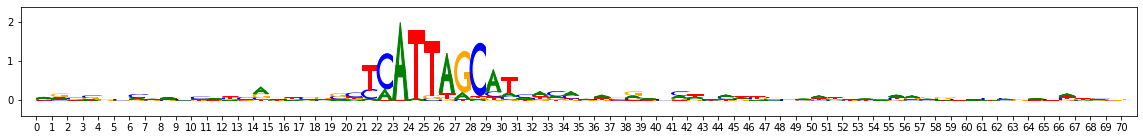

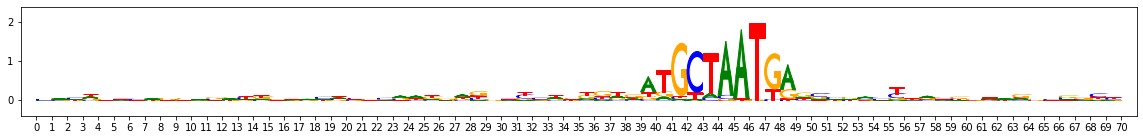

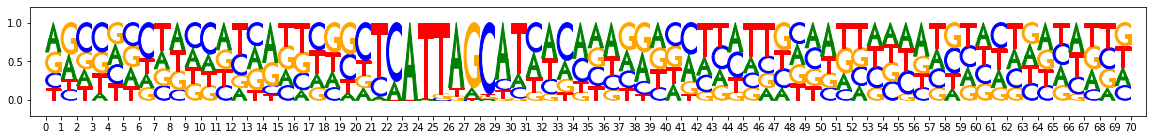

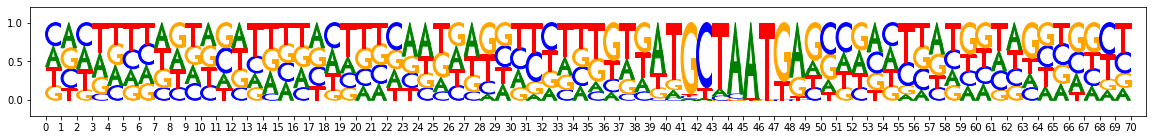

In [8]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("Hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background))
        viz_sequence.plot_weights(pattern["sequence"]["fwd"]) 
        viz_sequence.plot_weights(pattern["sequence"]["rev"]) 
        
hdf5_results.close()

### (extra) Visualize the result of using MEME's motifs to initialize the seqlets
This visualizes the intermediate stage where the MEME-derived motifs are used to create an initial set of seqlet clusters. Can be used to get insight into how the MEME-based initialization influenced the TF-MoDISco results

Inspecting meme-based initialization for seqlets in round 0
round 0 MEME-DISco motif number 0
num seqlets mapped to this motif: 237


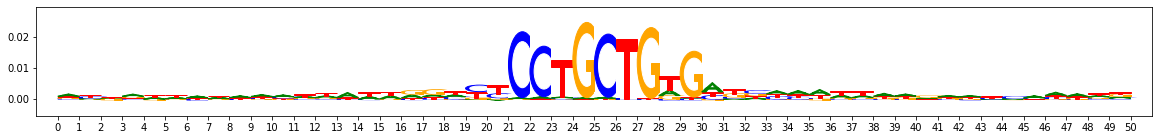

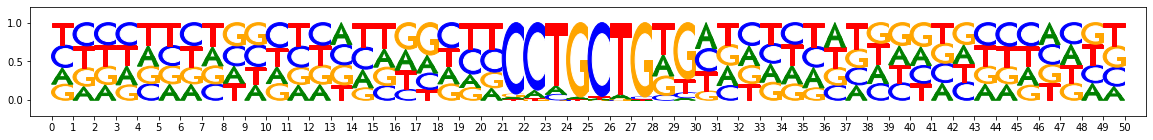

round 0 MEME-DISco motif number 1
num seqlets mapped to this motif: 150


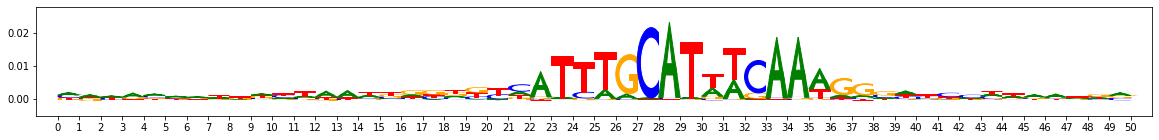

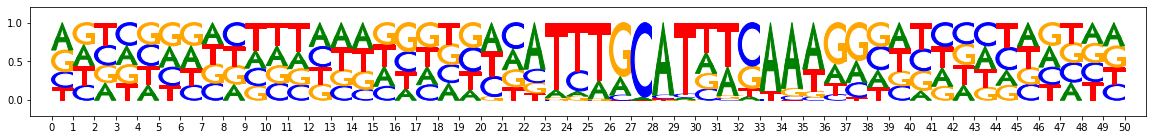

round 0 MEME-DISco motif number 2
num seqlets mapped to this motif: 147


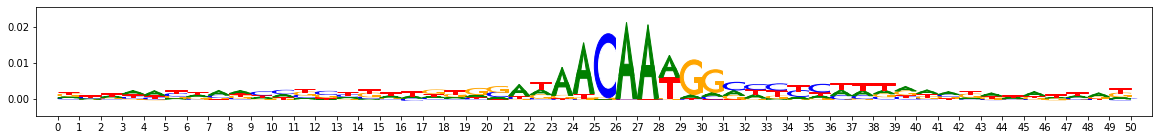

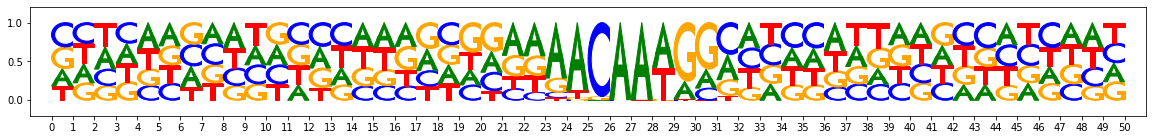

round 0 MEME-DISco motif number 3
num seqlets mapped to this motif: 141


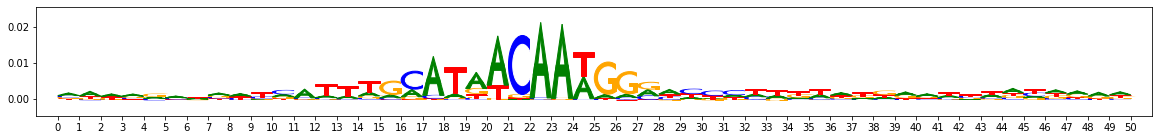

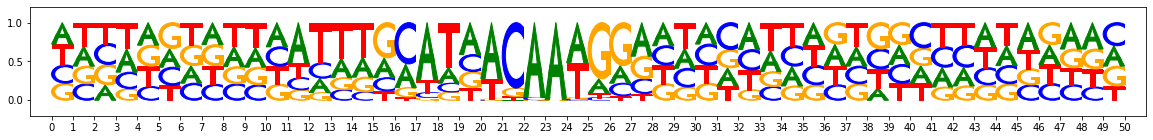

round 0 MEME-DISco motif number 4
num seqlets mapped to this motif: 51


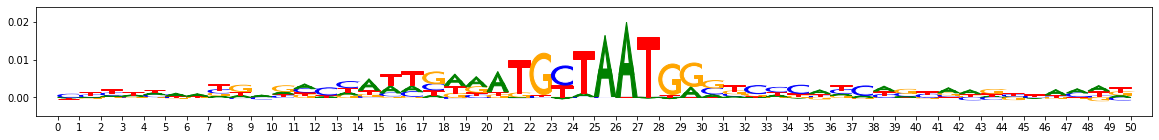

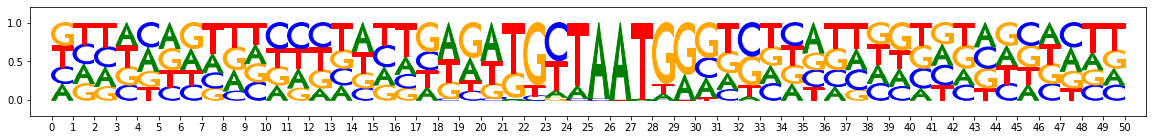

round 0 MEME-DISco motif number 5
num seqlets mapped to this motif: 45


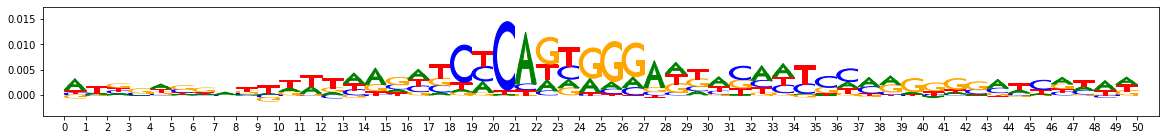

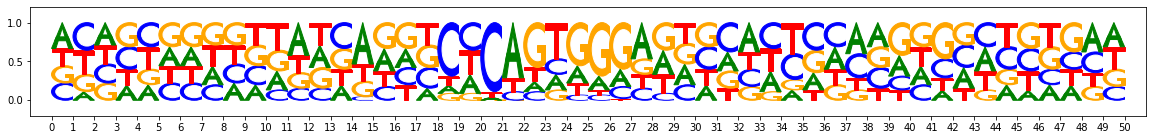

round 0 MEME-DISco motif number 6
num seqlets mapped to this motif: 33


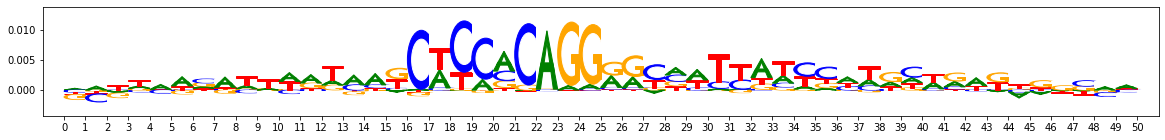

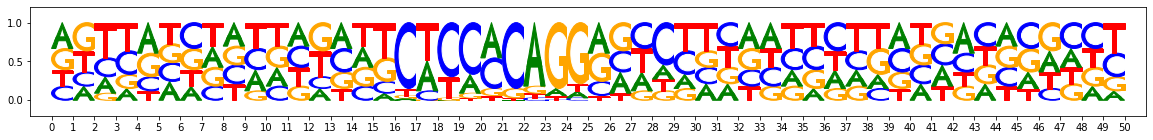

round 0 MEME-DISco motif number 7
num seqlets mapped to this motif: 19


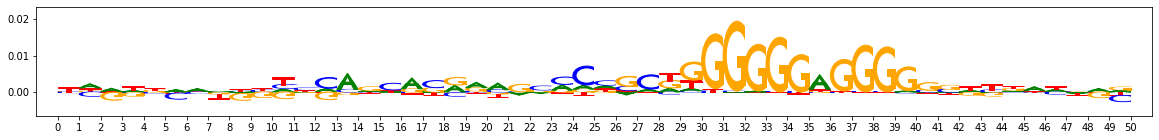

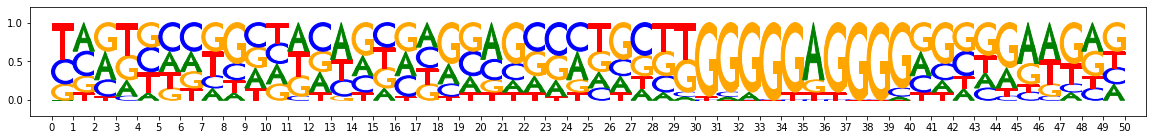

In [9]:
from modisco.visualization import viz_sequence
for round_idx in [0]:
    print("Inspecting meme-based initialization for seqlets in round",round_idx)
    meme_discovered_motifs = (tfmodisco_results
        .metacluster_idx_to_submetacluster_results[0].seqlets_to_patterns_result
        .each_round_initcluster_motifs[0])
    for idx,motif in enumerate(meme_discovered_motifs):
        print("round",round_idx,"MEME-DISco motif number",idx)
        print("num seqlets mapped to this motif:",len(motif.seqlets))
        viz_sequence.plot_weights(motif["task0_contrib_scores"].fwd)
        viz_sequence.plot_weights(motif["sequence"].fwd)